# Multi-Class Classification - Fine Tune DeBERTa on Amazon Customer Reviews Dataset
* Notebook by Adam Lang
* Date: 11/13/24

# Overview
* In this notebook I will demonstrate how to fine tune DeBERTa on an Amazon Customer Reviews Dataset.
* We will do this:

1. Fine Tune Deberta-base-v3 encoder model from huggingface.
2. Apply mean pooling on final hidden states.

# What is DeBERTa?
* DeBERTa has differences compared to BERT and RoBERTa, mainly two key mechanisms:
1. Disentangled attention
  * disentangled attention mechanism differs from all existing approaches in that each input word is represented using 2 separate vectors that encode a words content and position, respectively.
  * The key difference is that instead of adding the two vectors we treat them separately throughout the network.


2. Enhanced mask decoder
  * Following the footsteps of BERT, DeBERTa uses the masked language modeling task (MLM) for its pre-training.
  * Since the model has access to only the relative positions and not the absolute positions it can be a problem in ambiguous cases.
  * The absolute positions need to complement the relative position embeddings to completely understand the spatial modality.
  * BERT ingests the absolute position in the input layer itself.
    * To give the model some context of the actual positions, the authors add them right after all the transformer layers but before the softmax layer for masked token prediction.
    * **In this way, DeBERTa captures the relative positions in all the transformer layers and only uses absolute positions as complementary information when decoding the masked words. Thus, the name enhanced masked decoder.**

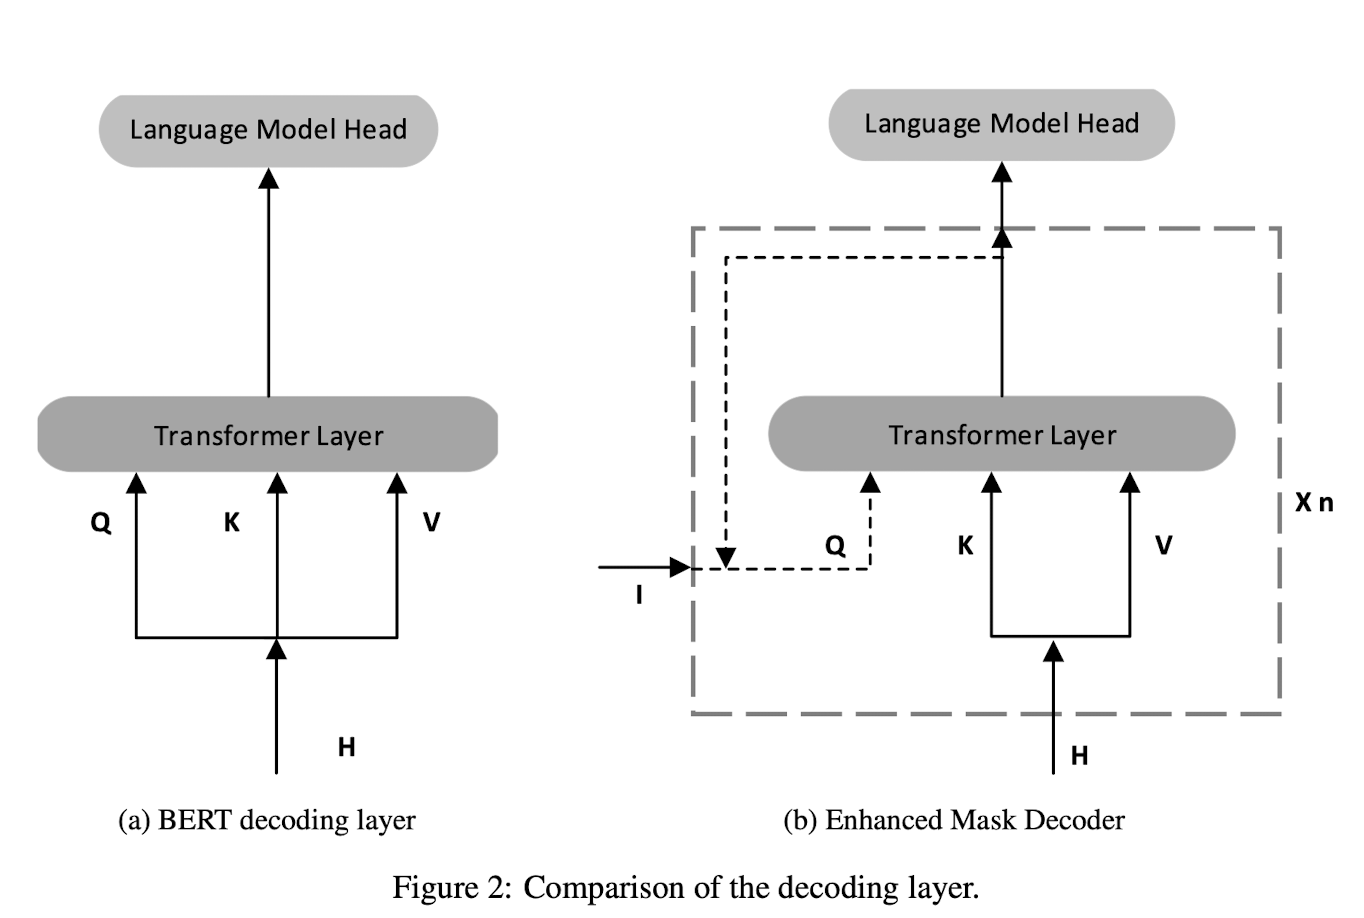


# Why would you use DeBERTa?
* With relative position bias in the mix, the authors chose to truncate the maximum relative distance to k. As a result in each layer, any token can attend directly to `2(k−1)` tokens and itself.
* By further stacking the transformer layers each token in `lth`layer can then implicitly attend to at most `(2k−1)L`
 tokens and itself.
* This theoretically enables the DeBERTa Large model `(k=512, L=24)` to have a **max sequence length of 24528.**
* **This makes DeBERTa a great choice for long sequences as opposed to RoBERTa.**
* Apart from long sequences DeBERTa models both base and Large have proven to be better than RoBERTa for various downstream NLP tasks.

Source: https://wandb.ai/akshayuppal12/DeBERTa/reports/The-Next-Generation-of-Transformers-Leaving-BERT-Behind-With-DeBERTa--VmlldzoyNDM2NTk2

Source: https://huggingface.co/blog/Valerii-Knowledgator/multi-label-classification


In [34]:
!pip install wandb

# Log into Weights and Biases

In [37]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [1]:
!pip install colorama

In [2]:
## data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## python imports
import os
import gc
import copy
import time
import random
import string
import joblib

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# transformer imports
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding

# color terminal text
from colorama import Fore, Back, Style

b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# for descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Setup CONFIG

In [39]:
## function for id_generator
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
  """This function `id_generator` is designed to create a random string with a
  specified length (default is 12 characters) from a set of provided characters.
  The purpose is to generate a unique, random identifier. """
  return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

HASH_NAME = id_generator(size=12)

In [40]:
## config
CONFIG = {"seed": 2022,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": "CosineAnnealingLR",
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 3,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "competition": "amazon-reviews-dataset",
          "_wandb_kernel": "react",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'

## Set Seed

In [41]:
## set seed for reproducible results
def set_seed(config):
  seed = config['seed']
  np.random.seed(seed)
  torch.manual_seed(seed)

  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  os.environ['PYTHONHASHSEED'] = str(seed)


# set seed
set_seed(CONFIG)


Summary of above function:

* This code snippet helps ensure consistent and reproducible results when working with libraries like NumPy and PyTorch that use random numbers or when using other operations that might involve randomness in your code.
* By setting these seed values, you guarantee that subsequent runs of your code with the same configuration will produce the same output, even if those operations are inherently stochastic.

# Upload Dataset

In [6]:
## import raw from github
import requests
from pathlib import Path #create file directory

# setup path to data folder
data_path = Path("data/")
file_path = data_path / "amazon_reviews"

# if the folder doesn't exist, download and prepare
if file_path.is_dir():
  print(f"{file_path} directory already exists... skipping download")
else:
  print(f"{file_path} does not exist, creating one...")
  file_path.mkdir(parents=True, exist_ok=True)


# Download the data
with open(data_path / "amazon_reviews.csv", "wb") as f:
  ## raw github or API link
  request = requests.get("https://raw.githubusercontent.com/rohan-paul/YT_Data_Sources/refs/heads/main/Amazon-Review-Text-NLP/amazon-review/cleaned_reviews_csv")
  print("Downloading dataset....")
  f.write(request.content) # write content of request to file

data/amazon_reviews does not exist, creating one...


In [7]:
## read in data
data_path = "/content/data/amazon_reviews.csv"
df = pd.read_csv(data_path)
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


# Explore and Process Data

In [8]:
## explore the data
print('df.shape is:', df.shape)
nan_count = df['cleaned_review'].isna().sum() #get sum of nan_count
print()
print(f"The nan_count is: {nan_count}")

df.shape is: (17340, 4)

The nan_count is: 3


In [9]:
## dropna
df.dropna(inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)


# nan_count after
nan_count_after = df['cleaned_review'].isna().sum()

#print nan_count_after
print(f"The nan_count after dropping null is: {nan_count_after}")

The nan_count after dropping null is: 0


# GroupKFold
* Group K-Fold is a method of cross-validation used in machine learning to ensure that the **data from different groups (such as different participants) are **not mixed or "leaked" between the training and testing sets.**
* This is particularly important when the data points are not independent and come from a few groups.

We want to prevent data leaking between train and test set.
* If we have the same data in the train and test set then that is data leakage.
* GroupKFold will help with this issue.

In [10]:
# assign group ids to unique reviews
# create numerical group identifier -- dataframe does not have unique id for each row
# identifier will be created by assigning unique ids to unique reviews

# `.factorize() --> get distinct values and numeric representation of array
# creates unique group identifiers
df['group'] = df['cleaned_review'].factorize()[0]

## GroupKFold
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

# loop over and assign kfolds
for fold, (_, val_index) in enumerate(gkf.split(X = df, groups=df['group'] )):
    df.loc[val_index, 'kfold'] = int(fold)
df['kfold'] = df['kfold'].astype(int)
df.head()



,sentiments,cleaned_review,cleaned_review_length,review_score,group,kfold
0,positive,i wish would have gotten one earlier love it a...,19,5.0,0,2
1,neutral,i ve learned this lesson again open the packag...,88,1.0,1,1
2,neutral,it is so slow and lags find better option,9,2.0,2,0
3,neutral,roller ball stopped working within months of m...,12,1.0,3,2
4,neutral,i like the color and size but it few days out ...,21,1.0,4,1


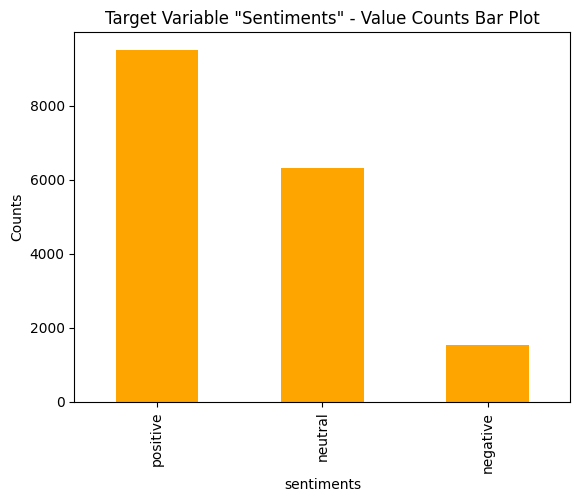

In [11]:
## lets look at the target sentiments column value_counts
df['sentiments'].value_counts().plot(kind='bar',color='orange')
plt.title('Target Variable "Sentiments" - Value Counts Bar Plot')
plt.ylabel('Counts')
plt.show();

In [12]:
## groupby kfolds
df.groupby('kfold')['sentiments'].value_counts()

kfold  sentiments
0      positive      3166
       neutral       2077
       negative       536
1      positive      3125
       neutral       2168
       negative       486
2      positive      3212
       neutral       2055
       negative       512
Name: count, dtype: int64

Summary:
* We are now able to see the kfolds represent each of the target variables evenly distributed.

In [13]:
## convert from categorical values ('positive','negative', 'neutral') to numerical values
encoder = LabelEncoder()
df['sentiments'] = encoder.fit_transform(df['sentiments'])

In [56]:
## check label encoder results
df['sentiments'].value_counts()

,count
sentiments,
2,9503
1,6300
0,1534


In [71]:
## columns
df.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length', 'review_score',
       'group', 'kfold'],
      dtype='object')

In [72]:
# rename "sentiments" column to "targets"

df = df.rename(columns={"sentiments": "targets"})
df.head()

,targets,cleaned_review,cleaned_review_length,review_score,group,kfold
0,2,i wish would have gotten one earlier love it a...,19,5.0,0,2
1,1,i ve learned this lesson again open the packag...,88,1.0,1,1
2,1,it is so slow and lags find better option,9,2.0,2,0
3,1,roller ball stopped working within months of m...,12,1.0,3,2
4,1,i like the color and size but it few days out ...,21,1.0,4,1


# Create PyTorch Dataset
* Let's recall that a PyTorch dataset has 3 essential parts:

1. **Initialization (__init__)**
  * This method initializes the dataset by loading the data and any necessary metadata.
  * It typically takes arguments like the data directory, file paths, or any other relevant information required to access and load the data.
2. **Length (__len__)**
  * This method returns the total number of samples in the dataset.
  * It's used by PyTorch's DataLoader to iterate over the dataset efficiently.
3. **Getting an Item (__getitem__)**
  * This method retrieves a single sample from the dataset given an index.
  * It fetches the corresponding data point (e.g., image, text, or numerical data) and any associated labels or targets.

In [197]:
## torch dataset
class TextDataset(Dataset):
  def __init__(self, df, tokenizer, max_length):
    self.df = df
    self.max_len = max_length
    self.tokenizer = tokenizer
    self.cleaned_review = df['cleaned_review'].values # access `cleaned_review` col from dataframe
    self.targets = df['targets'].values ## target variable is "sentiments"

  # total num of samples in dataset --> dataloader
  def __len__(self):
    return len(self.df)

  # retrieves sample from dataset given index
  def __getitem__(self, index):
    cleaned_review = self.cleaned_review[index]
    text = self.tokenizer.sep_token + " " + cleaned_review
    targets = self.df.loc[index, 'targets']
    inputs = self.tokenizer.encode_plus(
        cleaned_review,
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
    )

    return {
      'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
      'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
      'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
      'targets': torch.tensor(targets, dtype=torch.float)
            }



# DataCollatorWithPadding Setup
* `DataCollatorWithPadding` is a class in Hugging Face Transformers that helps in preparing batches of data for training transformer models. * Specifically, it is designed to handle cases where **input sequences have different lengths by dynamically padding them within a batch.**

* When training a transformer model, its common to batch sequences together for more efficient processing.
  * However, since sequences might have **different lengths**, they need to be **padded to a common length within each batch**.
  * **The DataCollatorWithPadding class automates this process.**

In [198]:
# setup collator
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

# Mean Pooling
## What the heck is pooling?
“Pooling is a form of data compression that can help reduce the computational complexity of deep learning models.” — Ian Goodfellow



## Why use mean pooling?
* One of the main advantages of pooling is that it can improve the performance of the model.
* Pooling helps to **extract the most important features from the input image and discard the less important ones.**
* This especially helps in **reducing overfitting**, which is a common problem in machine learning.
* Overfitting occurs when a model is too complex and fits the training data too well, resulting in poor performance on new data.
* **Pooling helps to reduce overfitting by reducing the dimensionality of the feature maps.**

Source: https://mohitmishra786687.medium.com/pooling-a-key-concept-in-machine-learning-81c05dcbce98

## Quick note about mean pooling
* SentenceTransformer embeddings use mean pooling by defaults.
* "CLS pooling" refers to using the embedding of the special "Classify" (`[CLS]`) token as the representation of a sentence, while "mean pooling" calculates the average of all the word embeddings within a sentence to create a single sentence embedding.
* Essentially, CLS pooling only considers the information encoded in the `[CLS]` token, while mean pooling takes into account the entire sentence by averaging all its word embeddings.


In [199]:
## mean pooling function
class MeanPooling(nn.Module):
    """Creates Mean Pooling to hidden state of entire transformer model.
    This is used to create a single vector representation of input sequence
    Useful for classification tasks such as this.
    """
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        # Expand Attention Mask -> to same shape as last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        # -> (batch_size, sequence_length, hidden_size)

        # sum embeddings
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)

        # sum mask --> sum expanded mask along sequence length dimension
        sum_mask = input_mask_expanded.sum(1)

        # avoid division by zero
        sum_mask = torch.clamp(sum_mask, min=1e-9)

        # calculate mean_embedding -- of all tokens
        mean_embedding = sum_embeddings / sum_mask

        return mean_embedding

# Create Model

In [200]:
## now we can create the model itself
class TextModel(nn.Module):
  def __init__(self, model_name) -> None:
    super(TextModel, self).__init__()
    self.model = AutoModel.from_pretrained(model_name)
    self.config = AutoConfig.from_pretrained(model_name)
    self.model.config.use_cache=False #enables gradient check pointing --> prolongs training process but reduces memory usage
    self.drop = nn.Dropout(p=0.2) ## default is 0.5 -- randomly zeros some of inputs
    self.pooler = MeanPooling() ## mean pooling function
    self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes']) #fully connected layer

  # forward pass
  def forward(self, ids, mask):
    #output
    out = self.model(input_ids = ids, attention_mask = mask, output_hidden_states = False)
    out = self.pooler(out.last_hidden_state, mask)
    out = self.drop(out)
    outputs = self.fc(out)
    return outputs


## Loss Function

In [201]:
## loss function
def criterion(outputs, labels):
  return nn.CrossEntropyLoss()(outputs, labels)

# Training Function

In [202]:
## training function
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for step, data in bar:
        input_ids = data['input_ids'].to(device, dtype=torch.long)
        attention_mask = data['attention_mask'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        batch_size = input_ids.size(0)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)

        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss



# Validation Function

In [203]:
## validation/testing function
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))

    for step, data in bar:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device, dtype=torch.long)

        batch_size = input_ids.size(0)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_loss=epoch_loss)

    gc.collect()
    return epoch_loss

# Train the model

In [204]:
## train function
def run_training(model,
                 optimizer,
                 scheduler,
                 train_loader,
                 valid_loader,
                 device,
                 num_epochs,
                 fold):
  """
  Function to train and validate a PyTorch model for specified num of epochs.

  Parameters:
    - model (torch.nn.Module): model to train
    - optimizer (torch.optim.Optimizer): optimizer for the model
    - scheduler (torch.optim.lr_scheduler): learning rate scheduler
    - train_loader (torch.utils.data.DataLoader): DataLoader for training data
    - valid_loader (torch.utils.data.DataLoader): DataLoader for validation data
    - device (str): device to train on ("cpu" or "cuda")
    - num_epochs (int): num of epochas to train model for
    - fold (int): fold number inf k-folds cross validation

  Returns:
    - model (torch.nn.Module): trained model
    - history (dict): dictionary containing training and validation loss for each epoch


  """
  ## if using weights and biases
  wandb.watch(model, log_freq=100)

  # device agnostic
  if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

  # time training
  start = time.time()

  # store initial state of model
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = np.inf #numpy inf

  history = defaultdict(list)


  for epoch in range(1, num_epochs + 1):
    gc.collect() #collect garbage
    ## accum train & valid loss
    train_epoch_loss = train_one_epoch(model, optimizer, scheduler, dataloader=train_loader, device=CONFIG['device'], epoch=epoch)
    valid_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], epoch=epoch)

    # history
    history['Train Loss'].append(train_epoch_loss)
    history['Valid Loss'].append(valid_epoch_loss)

    ## if using weights and biases
    wandb.log({"Train Loss": train_epoch_loss})
    wandb.log({"Valid Loss": val_epoch_loss})

    # If validation loss improves, save model weights
    if valid_epoch_loss <= best_epoch_loss:
      print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {valid_epoch_loss})")
      best_epoch_loss = valid_epoch_loss
      run.summary["Best Loss"] = best_epoch_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      PATH = f"Loss-Fold-{fold}.bin"
      torch.save(model.state_dict(), PATH)
      # save model file from current directory
      print(f"Model Saved(sr_)")

    print()

  #end time
  end = time.time()

  # calculate time elapsed
  time_elapsed = end - start

  time_elapsed = end - start
  print('Training complete in {:.0f}h {:.0f}m {:0f}s'.format(
      time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
  print('Best Loss: {:4f}'.format(best_epoch_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model, history







In [205]:
## get dataloader function
def get_dataloader(fold):
  """
  Function returns train and validation data loaders for a given fold.

  Args:
    - fold (int): fold number for which to create data loaders.

  Returns:
    - Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]: Train and Validation data loaders
  """
  df_train = df[df.kfold != fold].reset_index(drop = True)
  df_valid = df[df.kfold == fold].reset_index(drop = True)

  # apply TextDataset function
  train_dataset = TextDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
  valid_dataset = TextDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

  # load data into DataLoaders -- num_workers to 0 uses CPU for data loading
  train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, num_workers=0, shuffle=False, pin_memory=True) #dont need to shuffle due to GroupKFold
  valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn, num_workers=0, shuffle=False, pin_memory=True)

  return train_loader, valid_loader



from typing import Optional
from torch.optim import Optimizer
from torch.optim.lr_scheduler import(
    _LRScheduler
)
def get_lr_scheduler(optimizer: Optimizer) -> Optional[_LRScheduler]:
  """
  Returns a learning rate scheduler based on the specified configuration.

  Args:
    - optimizer (torch.optim.Optimizer): The optimizer for which to get the scheduler.

  Returns:
    -> torch.optim.lr_scheduler._LRScheduler or None: The learning rate scheduler or None if no scheduler is specified.
  """
  scheduler_type = CONFIG.get('scheduler')

  if scheduler_type == "CosineAnnealingLR":
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG.get('T_max'), eta_min = CONFIG.get('min_lr'))


  elif scheduler_type == "CosineAnnealingWarmRestarts":
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG.get('T_0'), eta_min = CONFIG.get('min_lr'))


  elif scheduler_type is None:
    return None

  else:
    raise ValueError(f"Invalid scheduler specified: {scheduler_type}")


  return scheduler



# Start Training

In [ ]:
for fold in range(0, CONFIG['n_fold']):
  print(f"y{y_}====== Fold: {fold} ======{sr_}")
  run = wandb.init(project='DeBERTa finetune',
                   config=CONFIG,
                   job_type='Train',
                   group=CONFIG['group'],
                   tags=[CONFIG['model_name'], f'f{HASH_NAME}'],
                   name=f'{HASH_NAME}-fold-{fold}',
                   anonymous='must')


  train_loader, valid_loader = get_dataloader(fold = fold)
  model = TextModel(CONFIG['model_name'])

  #send to device
  model.to(CONFIG['device'])

  #optimizer & scheduler
  optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
  scheduler = get_lr_scheduler(optimizer)

  # run training
  model, history = run_training(model, optimizer, scheduler, train_loader, valid_loader, device=CONFIG['device'],
                                num_epochs=CONFIG['epochs'],
                                fold=fold)


  run.finish()

  #del model when done
  del model, history, train_loader, valid_loader
  _ = gc.collect()
  print()